M507 Individual Final Project

ECG Classification Task

Student ID: GH1019250

# Introduction

Electrocardiogram (ECG) is a simple graphic where you can check the rhythm of the heart via electrical activity. Cardiologists use ECGs to detect health problems like arrhythmias, coronary heart disease, heart attacks and cardiomyopathy. The changes in the electrical activity in the heart, can be detected by professionals. On the other hand, this ECGs can be represented in a dataframe easily by sampling.

With the help of developing deep learning technics, this sampled ECGs can be used to predict the possible heart diseases. In this project, a Convolutional Neural Network (CNN) will be used to predict the class of the given ECG. To find the best model, different experiments will be conducted during the study. These experiments will be mainly about changing the layers, number of filters and layer sizes of CNN.

In this task, an ECG Classification with 5 labels have been conducted. The dataset used in the project is the MIT-BIH Arrhythmia Dataset. The Dataset has 109.444 samples in total, with a sampling rate of 125Hz.

The classes of the label frame is as follows:

Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

Note: You can reach the dataset from the following link: https://www.kaggle.com/datasets/shayanfazeli/heartbeat

# Building the Pipeline

## Loading Libraries

We are going to import the libraries and functions which will be used during the study. Some general libraries will be used in this project, such as pandas, numpy, seaborn and also some special lilbraries from tensorflow will be used to create our CNN.

In [52]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

## Importing dataset

Our dataset is consisting of two datasets where train and test datasets are splitted. We are going to use read_csv from pandas to import our datasets.

In [42]:
df_train = pd.read_csv('mitbih_train.csv')
df_test = pd.read_csv('mitbih_test.csv')
print(f'Shape of the train dataset is: {df_train.shape} \n\
Shape of the test dataset is: {df_test.shape}')

Shape of the train dataset is: (87553, 188) 
Shape of the test dataset is: (21891, 188)


## Target Label

Our target label is the last column and has the values of classes 0, 1, 2, 3 and 4. With using iloc and the index of the column, which is 187 in our case, we can easily preview the target label.

In [43]:
df_train.iloc[:, 187].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 0.000000000000000000e+00.88, dtype: float64

Renaming target feature as Classes in both test and train sets.

In [44]:
df_train.rename(columns={df_train.columns[187]:"Classes"}, inplace=True)
df_test.rename(columns={df_test.columns[187]:"Classes"}, inplace=True)

In this phase, we want to see the distribution of the target label. With the help of seaborn, we will visualize the number of incidents for each label.

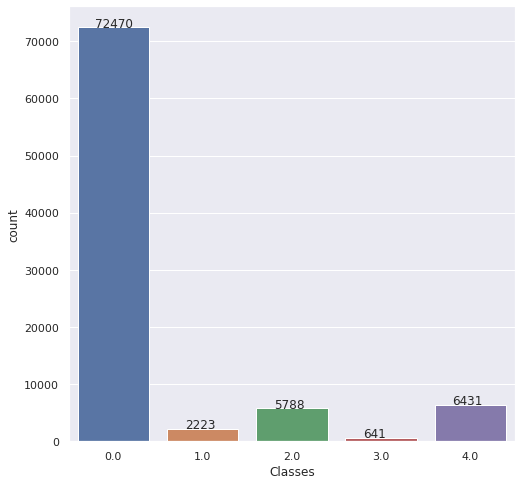

In [45]:
sns.set_theme(style="dark")
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.countplot(x="Classes", data=df_train)
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+0.01))

Now we are going to check for null values using isna() method for both test and train datasets.

In [46]:
df_train.isna().sum().sort_values(ascending=False).head()

9.779411554336547852e-01       0
0.000000000000000000e+00.30    0
0.000000000000000000e+00.21    0
0.000000000000000000e+00.22    0
0.000000000000000000e+00.23    0
dtype: int64

In [47]:
df_test.isna().sum().sort_values(ascending=False).head()

1.000000000000000000e+00      0
0.000000000000000000e+00.7    0
4.958677664399147034e-02.2    0
4.752065986394882202e-02.2    0
6.404958665370941162e-02      0
dtype: int64

To seperate the target label from the other features, we are using drop() method.

In [8]:
x_train_in = df_train.drop(["Classes"], axis=1)
y_train_in = df_train["Classes"]
x_test = df_test.drop(["Classes"], axis=1)
y_test = df_test["Classes"]

# Balancing Target Data

In this phase, we are going to run some experiments with different balance points in our dataset. To find out which balance point is better, we are going to use Random Forest Classifier and Classification Report. We are going to use RandomOverSampler and RandomUnderSampler to balance the data. Some other methods are also examined, their results can be seen in CNN experiments. 

To start with the experiments, we are going to apply RandomForestClassifier to our dataset before balancing. This will be our base model. Afterwards, we are going to balance our dataset at 15.000, 20.0000 and 25.000. According to the results, we are going to continue with the best choice.

## Base Model

Our Base Model will be a simple Random Forest Classifier trained with untouched data. We are going to observe how balance points changing our accuracy score.

In [9]:
rf = RandomForestClassifier()
base_model = rf.fit(x_train_in, y_train_in)
base_prediction = base_model.predict(x_test)

print(classification_report(y_test, base_prediction))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     18117
         1.0       0.99      0.59      0.74       556
         2.0       0.98      0.88      0.93      1448
         3.0       0.88      0.62      0.72       162
         4.0       1.00      0.94      0.97      1608

    accuracy                           0.97     21891
   macro avg       0.96      0.81      0.87     21891
weighted avg       0.97      0.97      0.97     21891



## Balance Point: 25.000 samples

In this part we are going to undersample the target label with the score of 0, and oversample the rest of the targets to reach the balance point of 25.000 samples for each label. Then, we are going to get classification report to compare our results with the base model and other models.

In [10]:
over25k = RandomOverSampler(sampling_strategy={1:25000, 2:25000, 3:25000, 4:25000}, random_state=13)
under25k = RandomUnderSampler(sampling_strategy={0:25000}, random_state=13)
x_over25k, y_over25k = over25k.fit_resample(x_train_in, y_train_in)
x_combined_25k, y_combined_25k = under25k.fit_resample(x_over25k, y_over25k)

In [11]:
equ25k_model = rf.fit(x_combined_25k, y_combined_25k)
equ25k_prediction = equ25k_model.predict(x_test)

print(classification_report(y_test, equ25k_prediction))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     18117
         1.0       0.86      0.72      0.78       556
         2.0       0.95      0.93      0.94      1448
         3.0       0.81      0.69      0.75       162
         4.0       0.98      0.97      0.98      1608

    accuracy                           0.98     21891
   macro avg       0.92      0.86      0.89     21891
weighted avg       0.98      0.98      0.98     21891



## Balance Point: 20.000 samples

Same process will be repeated for the balance point of 20.000 samples.

In [12]:
over20k = RandomOverSampler(sampling_strategy={1:20000, 2:20000, 3:20000, 4:20000}, random_state=13)
under20k = RandomUnderSampler(sampling_strategy={0:20000}, random_state=13)
x_over20k, y_over20k = over20k.fit_resample(x_train_in, y_train_in)
x_combined_20k, y_combined_20k = under20k.fit_resample(x_over20k, y_over20k)

In [13]:
equ20k_model = rf.fit(x_combined_20k, y_combined_20k)
equ20k_prediction = equ20k_model.predict(x_test)

print(classification_report(y_test, equ20k_prediction))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     18117
         1.0       0.85      0.74      0.79       556
         2.0       0.94      0.93      0.94      1448
         3.0       0.80      0.73      0.77       162
         4.0       0.98      0.97      0.97      1608

    accuracy                           0.98     21891
   macro avg       0.91      0.87      0.89     21891
weighted avg       0.98      0.98      0.98     21891



## Balance Point: 15.000 samples

Same process will be repeated for the balance point of 15.000 samples.

In [14]:
over15k = RandomOverSampler(sampling_strategy={1:15000, 2:15000, 3:15000, 4:15000}, random_state=13)
under15k = RandomUnderSampler(sampling_strategy={0:15000}, random_state=13)
x_over15k, y_over15k = over15k.fit_resample(x_train_in, y_train_in)
x_combined_15k, y_combined_15k = under15k.fit_resample(x_over15k, y_over15k)

In [15]:
equ15k_model = rf.fit(x_combined_15k, y_combined_15k)
equ15k_prediction = equ15k_model.predict(x_test)

print(classification_report(y_test, equ15k_prediction))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18117
         1.0       0.80      0.76      0.78       556
         2.0       0.92      0.94      0.93      1448
         3.0       0.77      0.75      0.76       162
         4.0       0.98      0.97      0.97      1608

    accuracy                           0.97     21891
   macro avg       0.89      0.88      0.89     21891
weighted avg       0.97      0.97      0.97     21891



According to the results, 25.000 samples has the best results. But on the other hand, 20.000 samples also has similar scores. In this case we are going to continue with 20.000 balance point to avoid more syntetic datapoints.

# CNN

Our data is ready to continue training our Deep Learning Algorithm. We are going to start with reshaping our data to fit our model. And also we are going to use to_categorical from keras to ready our target label.

In [16]:
x_train = np.array(x_combined_20k).reshape(x_combined_20k.shape[0], x_combined_20k.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
y_train = to_categorical(y_combined_20k, 5)
y_test = to_categorical(y_test, 5)

## Creating the Model

Since our data is ready for training, now we are going to create our model. Different experiments are conducted with the changes in this model, by changing the layers, layer sizes and number of filters. 

Since our samples are represented in a linear form, we are going to use 1 Dimensional attributes while creating our model.

Following the best model is represented. Conv1D is a 1 dimension convolution layer, which creates a convolution kernel with the given size and convolves the input with the given number of filters. BatchNormalization used afterwards to accelerate and stabilize the model by normalizing. After that, we are using MaxPool1D to downsample our data created by convolution. This steps repeat 2 more times with different number of filters.

Then in the end, we are getting the outputs with 2 Dense layers. In the last layer the size is equal to our number of classes which is 5.

We used relu activation function in our convolutions and first dense layer. Relu function, basically gives the output if the input is positive. In the last dense layer, we used softmax as the activation function. Softmax is used for multiclass tasks and normalizes the output according to the probability distrubition of given classes.

In [48]:
input_shape=(x_train.shape[1],1)

model = Sequential()

model.add(Input(shape=input_shape))
model.add(Conv1D(128, kernel_size=(3,), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(3,), strides=2))
model.add(Conv1D(64, kernel_size=(3,), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(3,), strides=2))
model.add(Conv1D(128, kernel_size=(3,), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(3,), strides=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation="relu"))
model.add(Dense(5, activation="softmax"))
          
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 185, 128)          512       
_________________________________________________________________
batch_normalization_4 (Batch (None, 185, 128)          512       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 92, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 90, 64)            24640     
_________________________________________________________________
batch_normalization_5 (Batch (None, 90, 64)            256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 44, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 42, 128)          

In the summary, we can see that how many parameters we have for each layer. And also the total number of parameters, trainable parameters and non-trainable parameters.

Following, we are going to run our model with the given parameters. To start with, we are going to call an early stopping to avoid overfitting. This early stopping will monitor validation loss, and will stop the algorithm early if necessary. When we are compiling our model, we are using Adam Optimization. To calculate the loss we are going to check categorical crossentropy and we want to see accuracy as the score of the model. 

History is to keep track of our loss and accuracy scores in both test and train sets. For this purpose, we are giving our model our train sets as input and test sets as validation data. 

In [49]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=33, callbacks=callbacks, validation_data=(x_test, y_test))

Epoch 1/33
3125/3125 [==============================] - 57s 18ms/step - loss: 0.3389 - accuracy: 0.8773 - val_loss: 0.2649 - val_accuracy: 0.9060
Epoch 2/33
3125/3125 [==============================] - 56s 18ms/step - loss: 0.1809 - accuracy: 0.9345 - val_loss: 0.2756 - val_accuracy: 0.8973
Epoch 3/33
3125/3125 [==============================] - 57s 18ms/step - loss: 0.1407 - accuracy: 0.9492 - val_loss: 0.2175 - val_accuracy: 0.9227
Epoch 4/33
3125/3125 [==============================] - 66s 21ms/step - loss: 0.1174 - accuracy: 0.9574 - val_loss: 0.1956 - val_accuracy: 0.9322
Epoch 5/33
3125/3125 [==============================] - 67s 22ms/step - loss: 0.1033 - accuracy: 0.9637 - val_loss: 0.1502 - val_accuracy: 0.9487
Epoch 6/33
3125/3125 [==============================] - 56s 18ms/step - loss: 0.0935 - accuracy: 0.9672 - val_loss: 0.1458 - val_accuracy: 0.9548
Epoch 7/33
3125/3125 [==============================] - 58s 19ms/step - loss: 0.0864 - accuracy: 0.9696 - val_loss: 0.1301 -

Our model stopped early at the 14th Epoch because of our command. The experiments conducted are listed as follows.

## Experiments

### Smote+Near Miss instead of Random Over and Under Sampler
The experiments started with only 1 batch normalization after dropout layer. The first experiments conducted with 64-64-64 Convolution Filters and 64-32-64 Convolution Filters. The validation accuracy scores are 0.7490 and 0.7963 respectively.

### Random Over and Under Sampler

The experiment conducted with 64-32-64, 64-128-64, 16-32-64, 128-64-128 and 128-64-32 Convolution Filters. The accuracy scores for validation are 0.9210, 0.9297, 0.9126, 0.9437 and 0.8714. 128-64-128 Convolutional Filters are kept for the future experiments.

### Adding Batch Normalization Layers

With 2 additional batch normalization layers, the algorithm started to work faster and our accuracy score has increased to 0.9501.

### Changing Number of Filters in Dense Layer

The experiments conducted with 32, 64 and 128 filters. Accuracy scores of the models are 0.9667, 0.9501 and 0.9323 respectively. 

With this last scores, we reach our best model with the validation accuracy score of 0.9667.

# Results

## Training Accuracy vs Validation Accuracy

To examine our accuracy scores in the end of each epoch for both training and validation sets, we are going to use the history variable that we have created. 

685/685 - 4s - loss: 0.1230 - accuracy: 0.9667


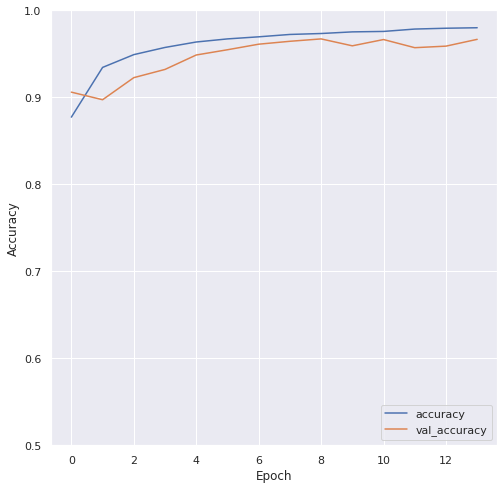

In [50]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

We can see that our train and validation accuracy scores are close to each other and moving nearly parallel. This shows us our training is successful and we have a high accuracy score which is near to 0.97. 

## Training Loss vs Validation Loss

We are going to see the difference between training and validation loss values. This will give us information if our model is overfitting or not. For this purpose, we are going to use our history variable again.

685/685 - 4s - loss: 0.1230 - accuracy: 0.9667


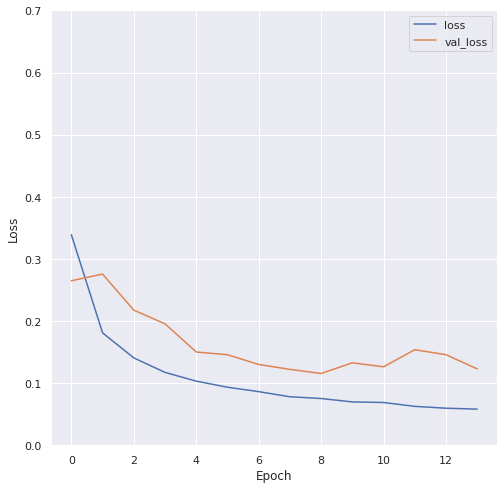

In [51]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.7])
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

With the inspection of the loss graphs, we can see that our model does not overfit yet. But it has a tendency to overfit. We can say that our early stop is working good in our case. And we have trained our model without an overfitting problem.

# Discussion and Conclusion

In our task we have used ECG samples to create a Convolutional Neural Networks model to predict heart related diseases. Our target label had 5 different classes. With the dataset created by the samples of ECG images with the frequency of 125Hz is used to train our model. At the end of experiments conducted with different over and under sapmling methods, different layers, different filter sizes and different layer sizes, we have reached our best CNN model. We have built a model which is working with 0.9667 accuracy score in validation set.

Our convolutional neural network model seems to be a good fit for the training set given. On the other hand, amount of synthetic data created with random over sampler is a lot, especially for Class 1 and Class 3. We are using low amount of data to reach 20.000 balance point. The results would be better if we had real data instead of the data that we have created to balance the feature targets. 

As conclusion, since this is a health related task, even 0.97 score is a big value. This algorithm cannot be used yet to detect heart related diseases. To improve the model, more data with the Classes 1, 2, 3 and 4 should be collected. Then this prediction task will have more success that we can use CNN in a health related task.